# GPR Dashboard Widgets

This notebook contains the outline for the dashboard skeleton. The widgets are not fully functioning yet, but will be under heavy construction over the next week. Widgets are expected to get werkin' by Monday April 30th.

Author: Sofia Ingersoll

To-Dos:
- Correct y-lim dim
- Expand reading function
- Get them widgets werkin!
- Plot titles match what will be selected via dashboard side, so we need to add the full names in dictionary for these to be called later
- Check 10 most common variables: GPP, NBP, TOTVEGC, TLAI, EFLX_LH_TOT, SOILWATER_10CM, QRUNOFF, FSR, FAREA_BURNED, SNOWDP

In [1]:
import xarray as xr
import pickle
from utils import * 

In [2]:
# Request an additional 10 cores of power for processing from the server
client = get_cluster("UCSB0021", cores = 30)
# apply peer2peer network communication across multiple devices
client.cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/singersoll/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.67:44873,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/singersoll/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [6]:
param, var, param_name, var_name = read_n_wrangle("leafcn","TOTVEGC")

In [17]:
var.shape

(500,)

In [8]:
param.shape

(500, 32)

In [7]:
gpr_model, y_pred, y_std, y_test, X_test, r2 = train_emulator(param, var)

R^2: 0.8102722037832238
RMSE: 697.4130984399462
Mean Absolute Error: 523.9635252824394


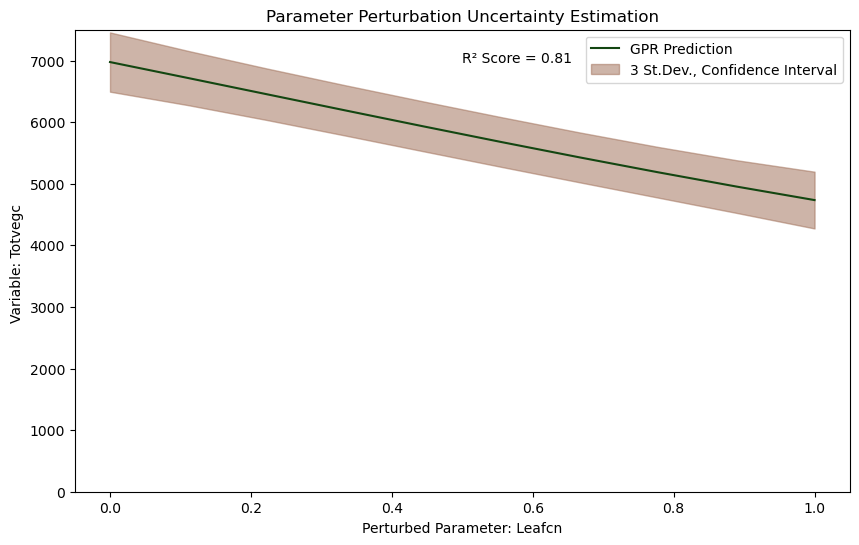

In [8]:
emulator_plot = plot_emulator(gpr_model, y_test, r2)

# Notes about potential tweaks
Need to double check w/ Dan, do we want the R^2 displayed to be the emulation R^2 or the corrcoef(y_test, y_pred). I would suspect it's the latter, but I have this random memory from an old meeting that is telling my the former, so I'm writing this note to double check. Currently it is the emulation r^2 generated in `train_emulator()`

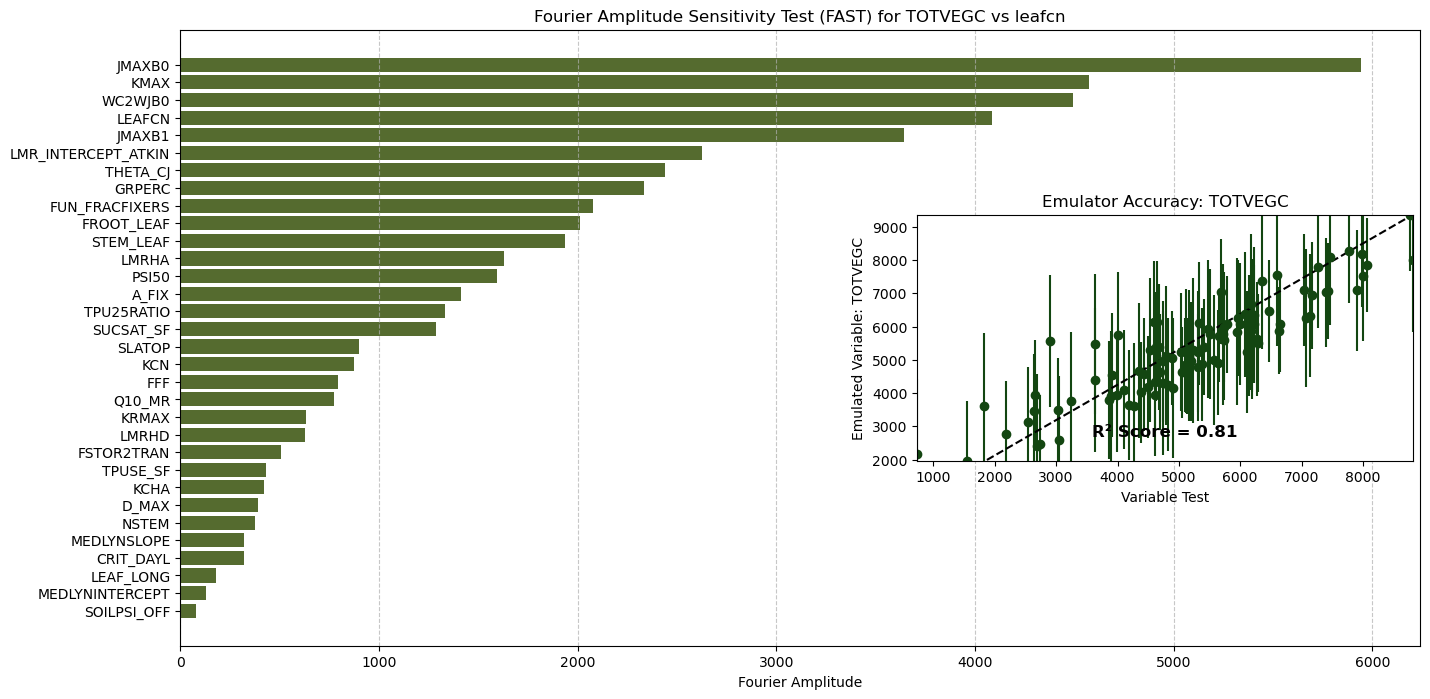

In [10]:
plot_FAST_accuracy(gpr_model, r2, y_test, y_pred, y_std)

## ylim 

In [11]:
def plot_emulator(gpr_model, y_test, r2_emulator):
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----      Visualize Emulation     ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
    # save names
    param_title = param_name.title()
    var_title = var_name.title()

    # index parameter name
    # store the parameter names to index later
    global param_names
    param_names = {
        key.upper(): value for key, value in {
            'FUN_fracfixers': 0, 'KCN': 1, 'a_fix': 2, 'crit_dayl': 3, 'd_max': 4, 'fff': 5,
            'froot_leaf': 6, 'fstor2tran': 7, 'grperc': 8, 'jmaxb0': 9, 'jmaxb1': 10, 'kcha': 11,
            'kmax': 12, 'krmax': 13, 'leaf_long': 14, 'leafcn': 15, 'lmr_intercept_atkin': 16,
            'lmrha': 17, 'lmrhd': 18, 'medlynintercept': 19, 'medlynslope': 20, 'nstem': 21,
            'psi50': 22, 'q10_mr': 23, 'slatop': 24, 'soilpsi_off': 25, 'stem_leaf': 26,
            'sucsat_sf': 27, 'theta_cj': 28, 'tpu25ratio': 29, 'tpuse_sf': 30, 'wc2wjb0': 31
        }.items()
    }
    
    indexed_param = param_names.get(param_name.upper())
    
    # Calculate the z-score for the 99.7% confidence interval
    # 99.7th percentile (three standard deviations)
    z_score = norm.ppf(0.99865)  
    
    
    #For the parameter of interest, replace the 0.5 with a range of values between 0 and 1
    X_values[:, indexed_param] = np.linspace(0, 1, 10)  # Set the 15th column values to evenly spaced values from 0 to 1

    # Predict mean and standard deviation of the Gaussian process at each point in x_values
    y_pred, y_std = gpr_model.predict(X_values, return_std=True)
    # using the emulator R2 value 
    coef_deter = r2_emulator
    #coef_deter = np.corrcoef(y_test[:10],y_pred[:10])[0,1]**2    # DOUBLE CHECK

    
    # Plot the results
    plt.figure(figsize=(10, 6))
    
    plt.plot(X_values[:, indexed_param],
             y_pred[:10,],
             color='#134611',
             label='GPR Prediction')

    plt.text(0.5,np.max(y_pred),
             'R² Score = '+str(np.round(coef_deter,2)),
             fontsize=10)
    
    # applying z-score for 99.7% CI
    plt.fill_between(X_values[:, indexed_param],
                     y_pred[:10] - z_score * y_std[:10], y_pred[:10] + z_score * y_std[:10],
                     alpha=0.5, 
                     color='#9d6b53',
                     label = '3 St.Dev., Confidence Interval')
    # TOTVEGC goes up to 7500
    plt.ylim([0, 7500])
    plt.xlabel(f'Perturbed Parameter: {param_title}')
    plt.ylabel(f'Variable: {var_title} ')
    plt.title('Parameter Perturbation Uncertainty Estimation')
    
    plt.legend()

     # Save the plot as a PNG file
    plt.savefig(f'plots/emulator/emulator_plot_{var_name}_{param_name}.png')
    
    return plt.show()

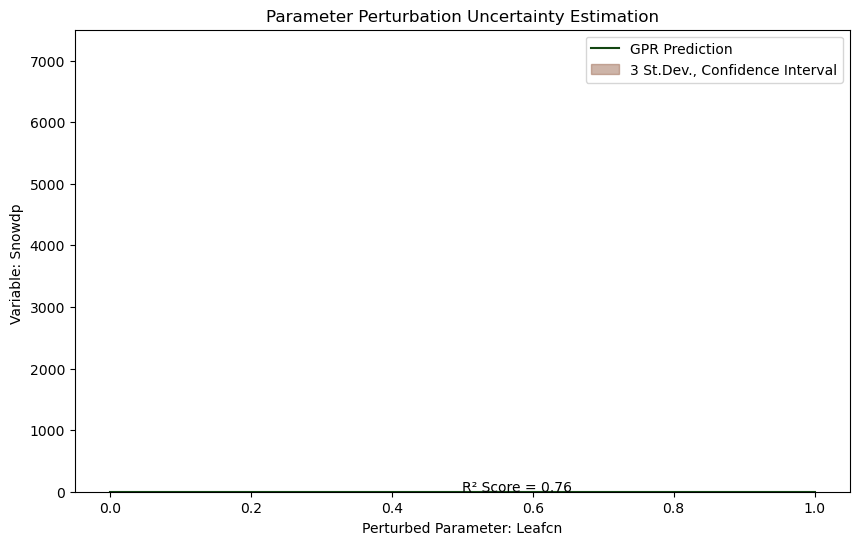

In [16]:
emulator_plot = plot_emulator(gpr_model, y_test, r2)

Accuracy plot looks awful when adjusting limits, lets keep those the same as before

In [11]:
def plot_FAST_accuracy(gpr_model, r2_train, y_test, y_pred, y_std):
    def gaussian_regression_lines(gpr_model):
        fourier_amplitudes = []
        
        for param_index in range(32):
            X_values = np.full((10, 32), 0.5)
            X_values[:, param_index] = np.linspace(0, 1, 10)
            y_pred, _ = gpr_model.predict(X_values, return_std=True)
            y_fft = fft(y_pred)
            amplitude = np.abs(y_fft)
            fourier_amplitudes.append(amplitude[1])

        return fourier_amplitudes

    fourier_amplitudes = gaussian_regression_lines(gpr_model)
    sorted_indices = np.argsort(fourier_amplitudes)
    sorted_fourier_amplitudes = np.array(fourier_amplitudes)[sorted_indices]
    swapped_param_keys = {v: k for k, v in create_parameter_names_dict().items()}
    sorted_parameter_names = [swapped_param_keys[index] for index in sorted_indices]

    fig, ax = plt.subplots(figsize=(16, 8))
    ax.barh(range(len(sorted_fourier_amplitudes)), sorted_fourier_amplitudes, color='darkolivegreen')
    ax.set_ylabel('')
    ax.set_xlabel('Fourier Amplitude')
    ax.set_title(f'Fourier Amplitude Sensitivity Test (FAST) for {var_name} vs {param_name}')
    ax.set_yticks(range(len(sorted_fourier_amplitudes)), sorted_parameter_names)
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    #ax.text(1, 0.5, f'R2_score = {np.round(r2_train,2)}', fontsize=10, transform=ax.transAxes)
    ax.set_aspect('auto', adjustable='box')

    # Create inset for accuracy plot
    ax_inset = inset_axes(ax, width="40%", height="40%", loc='center right')
    ax_inset.errorbar(y_test, y_pred, yerr=3*y_std, fmt="o", color='#134611')
    ax_inset.plot([0, np.max(y_test)], [0, np.max(y_pred)], linestyle='--', c='k')
    ax_inset.set_xlim([np.min(y_test)-1, np.max(y_test)+1])
    ax_inset.set_ylim([np.min(y_pred)-1, np.max(y_pred)+1])
    ax_inset.set_xlabel('Variable Test')
    ax_inset.set_ylabel(f'Emulated Variable: {var_name}')
    ax_inset.set_title(f'Emulator Accuracy: {var_name}')
    ax_inset.text(0.5, 0.1, f'R² Score = {np.round(r2_train, 2)}', fontsize=12, \
                  transform=ax_inset.transAxes, horizontalalignment='center', weight='bold')
    
     # Save the plot as a PNG file
    plt.savefig(f'plots/fast_accuracy/fast_acc_plot_{var_name}_{param_name}.png')

    return plt.show()

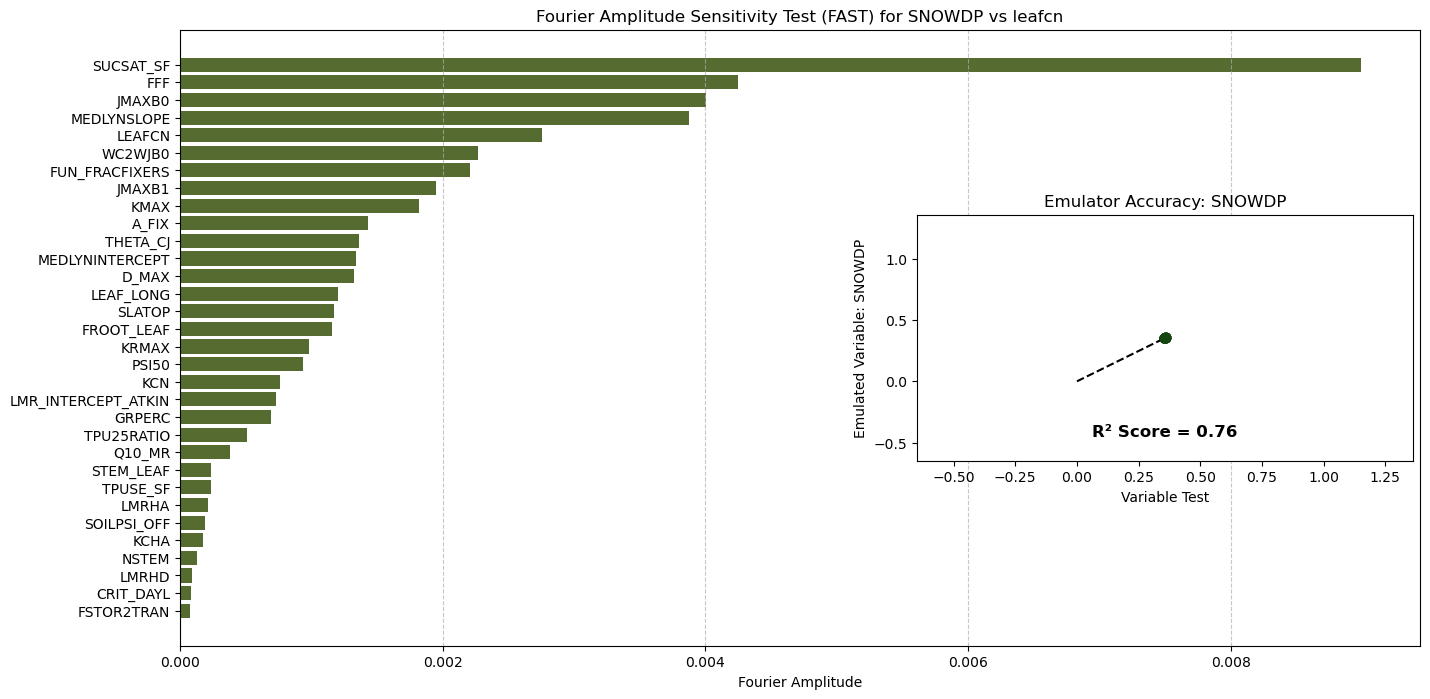

In [12]:
plot_FAST_accuracy(gpr_model, r2, y_test, y_pred, y_std)

## Units
What attribute is it labled under?

In [23]:
test = read_all_simulations("GPP")
#test = fix_time(test)
#test = yearly_weighted_average(test)
    # take global avg for variable over year dimension
#test = test.mean(dim='year')

In [24]:
test

<xarray.Dataset> Size: 48MB
Dimensions:  (lat: 96, lon: 144, time: 60, ens: 500, gridcell: 400)
Coordinates:
  * lat      (lat) float32 384B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) object 480B 2005-02-01 00:00:00 ... 2010-01-01 00:00:00
Dimensions without coordinates: ens, gridcell
Data variables:
    GPP      (ens, time, gridcell) float32 48MB dask.array<chunksize=(1, 60, 400), meta=np.ndarray>
Attributes: (12/40)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 08/10/23 00:09:45
    source:                                    Community Terrestrial Systems ...
    hostname:                                  cheyenne
    ...                                        ...
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1
    Time_constant_3Dvars_filename:             ./PPEn11_transient_LHC0001.clm...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...

# Dashboard

## Wrangling function

In [9]:
def dashboard_wrangling(param, var):
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----    Subset User Selection Funct     ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    params, var_avg, param_name, var_name = read_n_wrangle(param, var)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----       Train Emulator Function      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  
    gpr_model, y_pred, y_std, y_test, X_test, r2 = train_emulator(params, var_avg)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----       Plot Emulation Function      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
    Plot_1 = plot_emulator(gpr_model, y_test, r2)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----    Plot Accuracy Function      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
    Plot_2 = plot_FAST_accuracy(gpr_model, r2, y_test, y_pred, y_std)
    
    # Return both plots
    return pn.Row(Plot_1, Plot_2)

R^2: 0.9436217492785405
RMSE: 0.04635041296076164
Mean Absolute Error: 0.0363568749639293


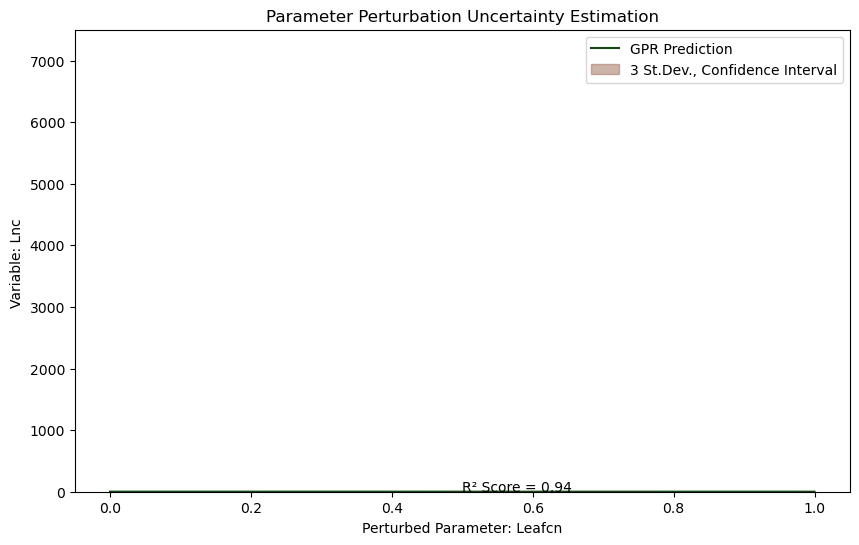

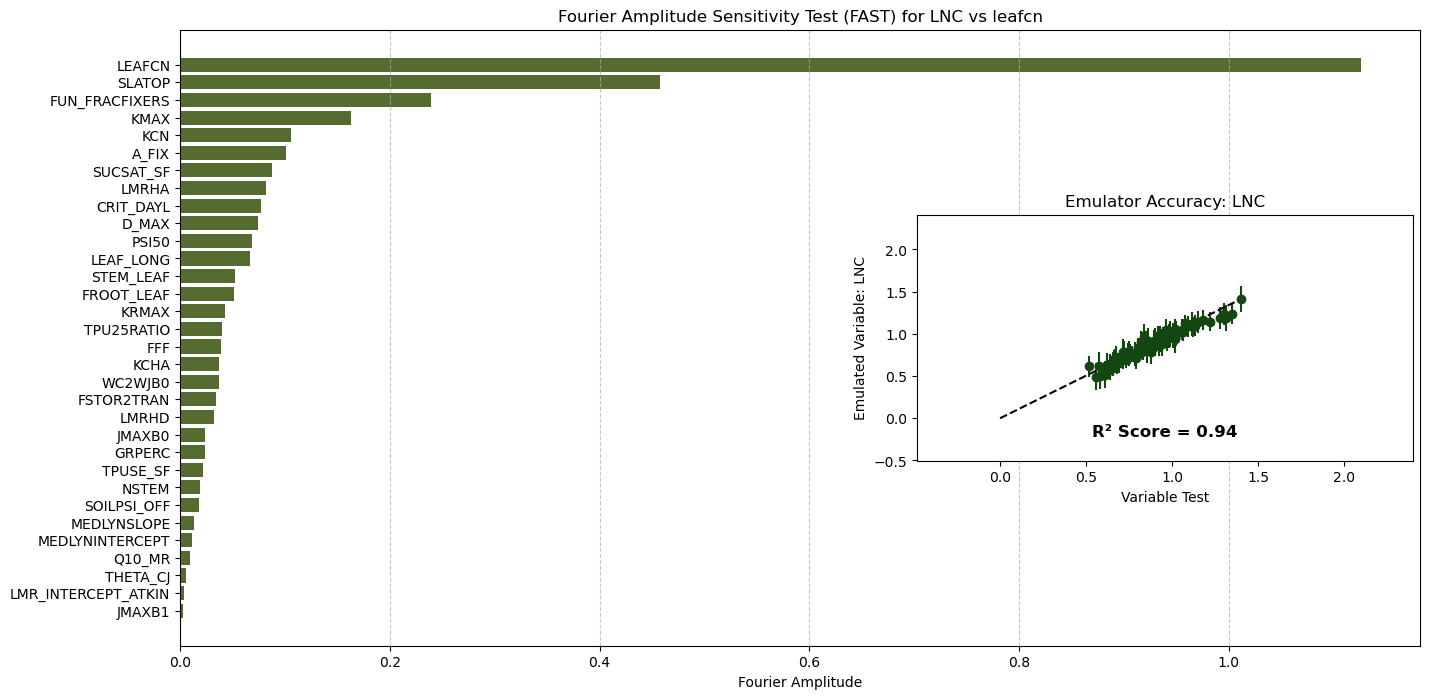

Row
    [0] Str(None)
    [1] Str(None)

In [10]:
dashboard_wrangling('leafcn', 'LNC')

## Working on Widgets

In [11]:
import param
def dashboard_wrangling(param, var):
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----    Subset User Selection Funct     ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    params, var_avg, param_name, var_name = read_n_wrangle(param, var)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----       Train Emulator Function      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  
    gpr_model, y_pred, y_std, y_test, X_test, r2 = train_emulator(params, var_avg)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----       Plot Emulation Function      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
    Plot_1 = plot_emulator(gpr_model, y_test, r2)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----    Plot Accuracy Function      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
    Plot_2 = plot_FAST_accuracy(gpr_model, r2, y_test, y_pred, y_std)
    
    pn.Row(Plot_1, Plot_2)

class Selections(param.Parameterized):
    parameter = param.Selector(objects=['leafcn'])
    variable = param.Selector(objects=['GPP', 'NBP', 'TOTVEGC', 'TLAI', 'EFLX_LH_TOT', 'SOILWATER_10CM', 'QRUNOFF', 'FSR', 'FAREA_BURNED', 'SNOWDP'])

    def view(self):
        # Call dashboard_wrangling with the selected parameter and variable
        plots = dashboard_wrangling(self.parameter, self.variable)

        # Convert Matplotlib figures to Panel objects
        plot_pane1 = pn.pane.Matplotlib(plots[0])
        plot_pane2 = pn.pane.Matplotlib(plots[1])

        # Return a Panel layout containing the converted Panel objects
        return pn.Column(plot_pane1, plot_pane2)

R^2: 0.7807394793728104
RMSE: 3.3481285983264553e-06
Mean Absolute Error: 2.554710015269346e-06


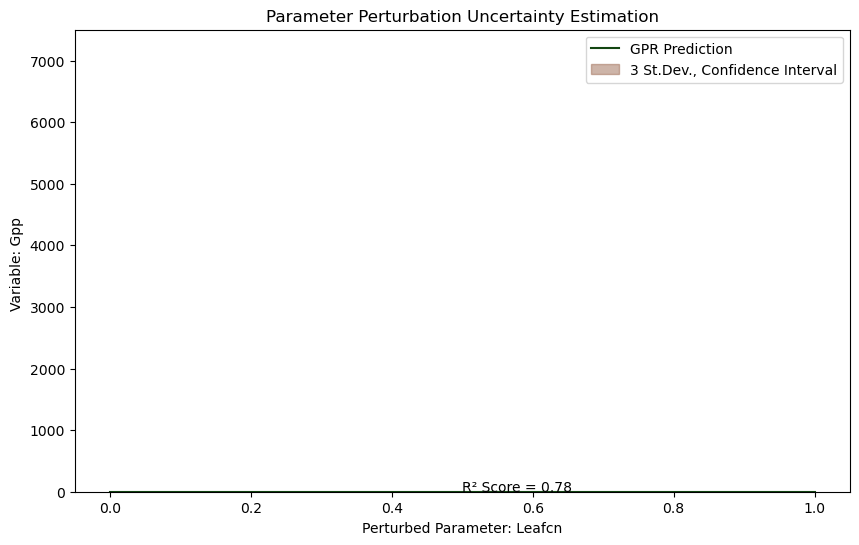

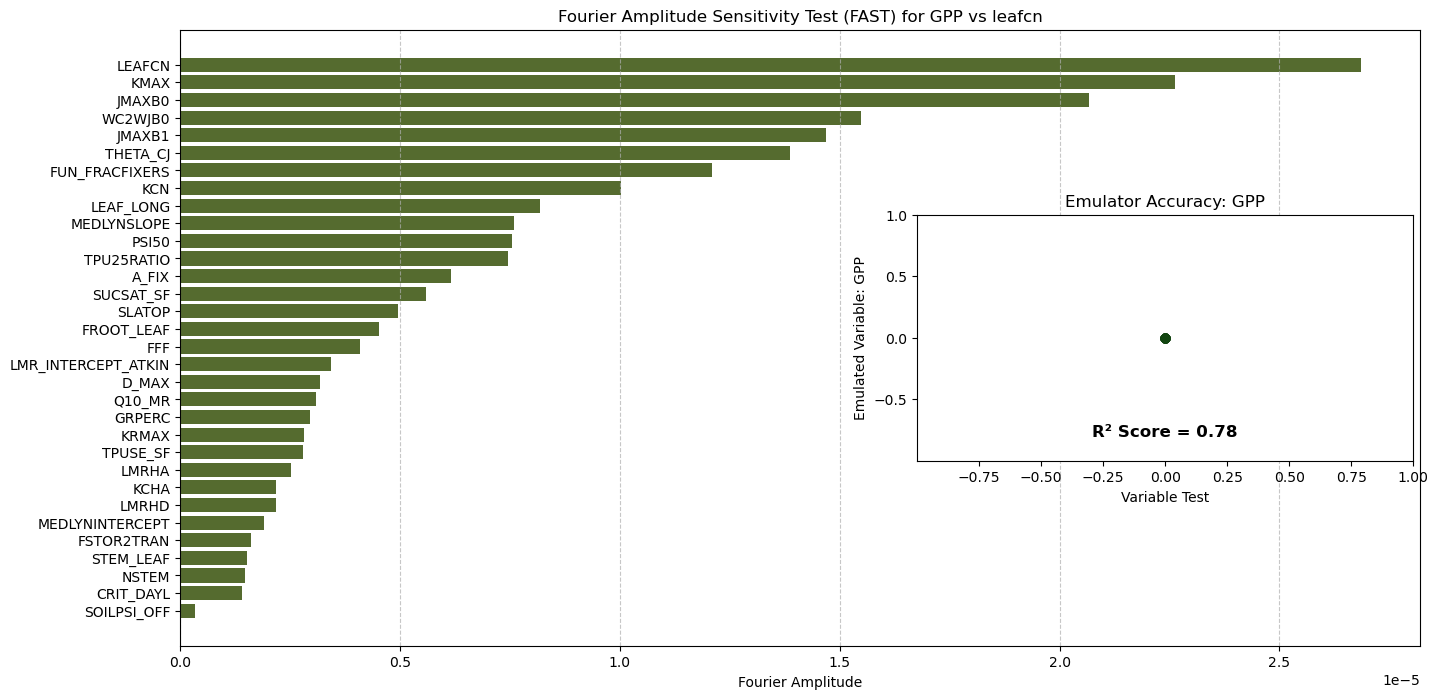

TypeError: 'NoneType' object is not subscriptable

In [12]:
# Create an instance of Selections and display it using Panel
obj = Selections()
pn.Row(obj.param, obj.view).servable()

In [ ]:
class Selections(param.Parameterized):
    parameter = param.Selector(objects=['leafcn'])
    variable = param.Selector(objects=['GPP', 'NBP', 'TOTVEGC', 'TLAI', 'EFLX_LH_TOT', 'SOILWATER_10CM', 'QRUNOFF', 'FSR', 'FAREA_BURNED', 'SNOWDP'])

    def view(self):
        # Call dashboard_wrangling with the selected parameter and variable
        plots = dashboard_wrangling_check2(self.parameter, self.variable)

        # Convert Matplotlib figures to Panel objects
        plot_pane1 = pn.pane.Matplotlib(plots[0])
        plot_pane2 = pn.pane.Matplotlib(plots[1])

        # Return a Panel layout containing the converted Panel objects
        return pn.Column(plot_pane1, plot_pane2)

# Create an instance of Selections and display it using Panel
obj = Selections()
pn.Row(obj.param, obj.view).servable()